In [3]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.8
scanpy      1.8.2
sinfo       0.3.4
-----
MulticoreTSNE               NA
PIL                         8.4.0
anyio                       NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
boltons                     NA
bottleneck                  1.3.2
brotli                      NA
cached_property             1.5.2
certifi                     2021.10.08
cffi               

In [33]:
adata_full = sc.read("Lung_TB_T_Cells_CITESEQ_RNA.h5ad")

In [34]:
adata_cd8 = adata_full[adata_full.obs.cluster_ids.isin(["C-24", "C-25", "C-26", "C-27", "C-28", "C-29"])]

In [35]:
adata_cd8

View of AnnData object with n_obs × n_vars = 53878 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

In [4]:
f_final_loom = "Lung_TB_CD8_T_Cells_CITESEQ_RNA_SCENIC.loom"

In [6]:
# scenic output
lf = lp.connect(f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame(lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [7]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [47]:
pd.DataFrame(adata.obs["cluster_name"], index=lf.ca.CellID)

,cluster_name
8,CD8+ GZMB+
18,CD4/8+ PD-1+TIGIT+
33,CD8+ GZMK+
40,CD8+ central
54,CD8+ GZMB+
...,...
500028,CD8+ GZMK+
500033,CD8+ GZMK+
500036,CD4/8+ PD-1+TIGIT+
500038,CD8+ GZMB+


In [25]:
adata = sc.read(f_final_loom, validate=False, cache=True)


# load the regulons from a file using the load_signatures function
sig = load_signatures('reg_CD8.csv')
adata = add_scenic_metadata(adata, auc_mtx, sig)

... writing an h5ad cache file to speedup reading next time
Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [38]:
adata.obs["cluster_ids"] = adata_cd8.obs["cluster_ids"]
adata.obs["cluster_name"] = adata_cd8.obs["cluster_name"]
adata.obs["TB_status"] = adata_cd8.obs["TB_status"]
adata.obs["percent_mito"] = adata_cd8.obs["percent_mito"]


In [49]:
cellAnnot = pd.concat([
        pd.DataFrame(lf.ca.nGene, index=lf.ca.CellID),
        pd.DataFrame(lf.ca.nUMI, index=lf.ca.CellID),
        pd.DataFrame(adata.obs["cluster_name"], index=lf.ca.CellID),
        pd.DataFrame(adata.obs["cluster_ids"], index=lf.ca.CellID)
], 
    axis=1)

cellAnnot.columns = ['nGene',
                     'nUMI',
                    "cluster_name",
                    "cluster_ids"]

In [31]:
auc_mtx

,AHR(+),ARID3A(+),ARID5A(+),ARNTL2(+),ATF3(+),ATF4(+),ATF5(+),ATF6(+),ATF6B(+),ATF7(+),...,ZNF607(+),ZNF66(+),ZNF677(+),ZNF76(+),ZNF768(+),ZNF772(+),ZNF85(+),ZNF91(+),ZSCAN10(+),ZSCAN31(+)
8,0.117778,0.016156,0.000000,0.025711,0.024729,0.067923,0.038390,0.008407,0.0,0.021232,...,0.0000,0.000000,0.000000,0.026368,0.000000,0.000000,0.000000,0.076467,0.000000,0.000000
18,0.000000,0.045188,0.000000,0.058493,0.075875,0.071500,0.070306,0.080221,0.0,0.035933,...,0.0000,0.000000,0.000000,0.024818,0.022569,0.023333,0.000000,0.122736,0.081042,0.000000
33,0.000000,0.034812,0.000000,0.018811,0.063646,0.049381,0.052187,0.026936,0.0,0.042219,...,0.1375,0.000000,0.000000,0.033429,0.100000,0.000000,0.030583,0.087252,0.000000,0.000000
40,0.058472,0.025833,0.000000,0.025576,0.045073,0.065798,0.052920,0.033873,0.0,0.013578,...,0.0000,0.076667,0.056944,0.052596,0.106528,0.046667,0.000000,0.107699,0.086875,0.000000
54,0.000000,0.030914,0.000000,0.094596,0.068281,0.113327,0.061859,0.016863,0.0,0.024121,...,0.0000,0.000000,0.065000,0.043066,0.000000,0.064667,0.086417,0.112711,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500028,0.093194,0.025860,0.049722,0.017377,0.066448,0.065315,0.033105,0.020147,0.0,0.038125,...,0.0000,0.000000,0.000000,0.025481,0.042292,0.000000,0.047917,0.110423,0.000000,0.000000
500033,0.158333,0.039704,0.005093,0.026887,0.046406,0.069863,0.054224,0.075515,0.0,0.012292,...,0.0000,0.017333,0.067870,0.034786,0.053125,0.000000,0.068500,0.070091,0.000000,0.055417
500036,0.282917,0.042715,0.000000,0.049412,0.058281,0.049786,0.024174,0.046103,0.0,0.032781,...,0.1075,0.000000,0.000000,0.020876,0.000000,0.000000,0.011250,0.077289,0.071771,0.000000
500038,0.109861,0.026882,0.159352,0.044534,0.104844,0.048714,0.039202,0.056176,0.0,0.024864,...,0.0000,0.000000,0.000000,0.069541,0.105486,0.042333,0.058417,0.096111,0.111667,0.000000


In [27]:
# helper functions (not yet integrated into pySCENIC):

from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [28]:
df_motifs = load_motifs('reg_CD8.csv')

In [29]:
selected_motifs = ['PAX5','TCF3','EBF1']
df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [30]:
#display_logos(df_motifs.head())
display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))


In [40]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [51]:
rss_cellType = regulon_specificity_scores(auc_mtx, cellAnnot['cluster_ids'])
rss_cellType

,AHR(+),ARID3A(+),ARID5A(+),ARNTL2(+),ATF3(+),ATF4(+),ATF5(+),ATF6(+),ATF6B(+),ATF7(+),...,ZNF607(+),ZNF66(+),ZNF677(+),ZNF76(+),ZNF768(+),ZNF772(+),ZNF85(+),ZNF91(+),ZSCAN10(+),ZSCAN31(+)
C-29,0.365411,0.421930,0.323916,0.427060,0.411313,0.425077,0.413919,0.395049,0.187732,0.413836,...,0.290011,0.294671,0.331871,0.413520,0.386551,0.287805,0.359839,0.412634,0.345823,0.242122
C-24,0.299630,0.302967,0.251592,0.317951,0.314476,0.316420,0.321265,0.318510,0.181908,0.321934,...,0.267994,0.260021,0.268238,0.320534,0.303037,0.255715,0.294609,0.319583,0.276088,0.223474
C-28,0.359071,0.365224,0.281164,0.395574,0.403174,0.401583,0.406569,0.389972,0.181974,0.398428,...,0.289890,0.287103,0.319908,0.401731,0.366218,0.277617,0.354021,0.402400,0.315726,0.235406
C-25,0.277364,0.257311,0.212787,0.274109,0.297499,0.289833,0.289476,0.280035,0.178539,0.282434,...,0.253445,0.238174,0.249866,0.283681,0.278809,0.224119,0.270834,0.291733,0.261978,0.205366
C-26,0.252841,0.238509,0.206686,0.251674,0.264255,0.258187,0.256001,0.255191,0.180936,0.256782,...,0.234463,0.226862,0.244155,0.261634,0.252626,0.212046,0.248375,0.264027,0.227895,0.199170
C-27,0.222910,0.203128,0.183035,0.212238,0.216995,0.225279,0.215318,0.211366,0.171155,0.211150,...,0.187763,0.190548,0.183481,0.207693,0.217031,0.190945,0.207204,0.219522,0.191659,0.178172


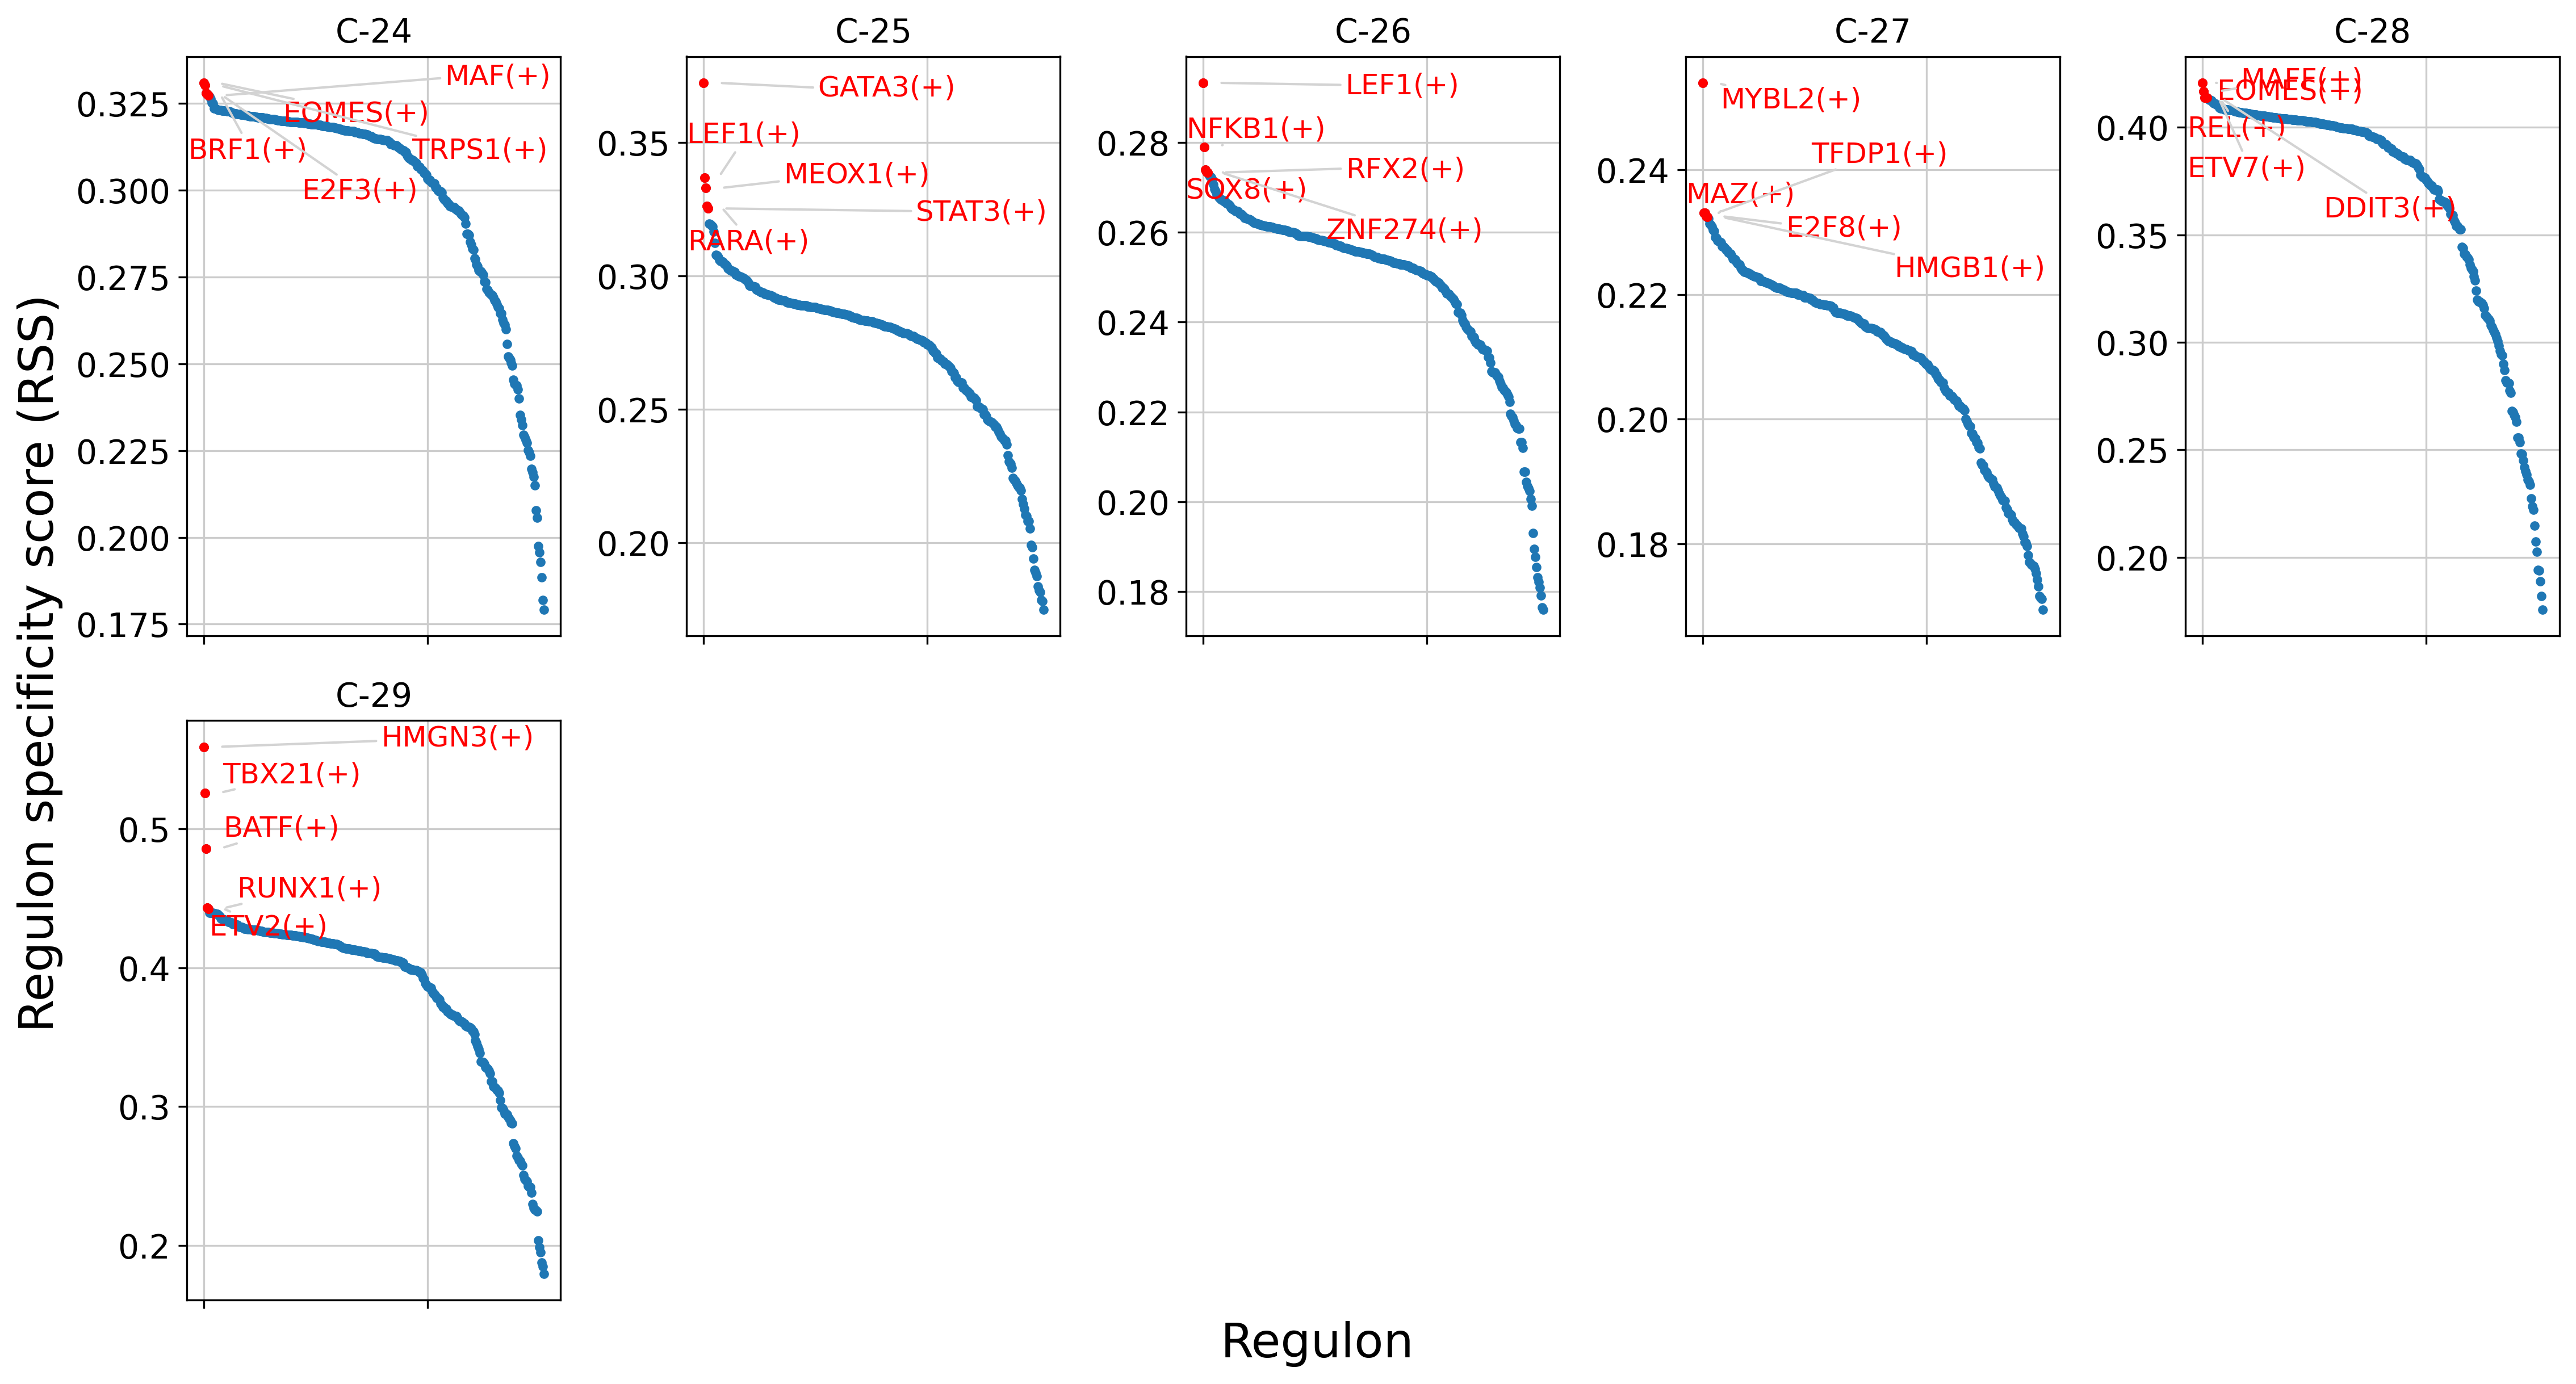

In [53]:
cats = sorted(list(set(cellAnnot['cluster_ids'])))

fig = plt.figure(figsize=(15, 8))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })

plt.show()

In [54]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [55]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

/home/icb/goeksu.avar/anaconda3/envs/pyscenic/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [56]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [57]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['cluster_ids'] ]

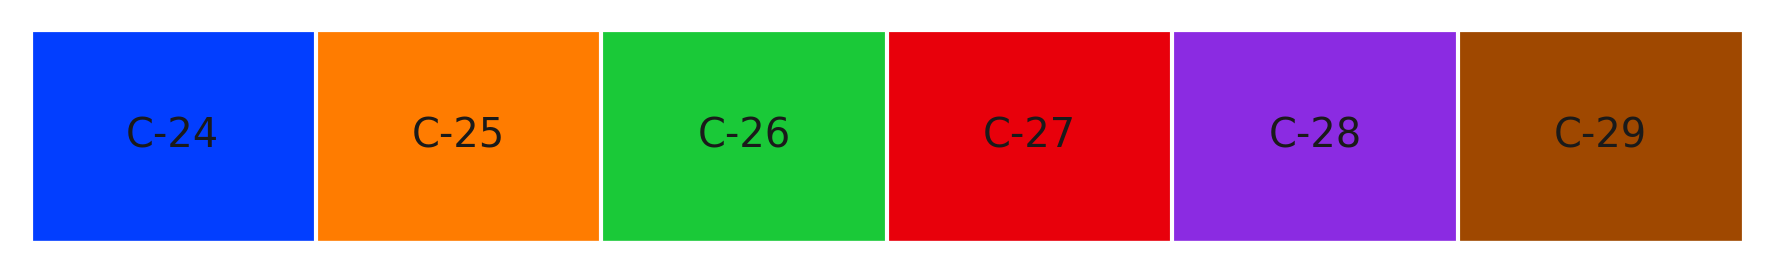

In [58]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

/home/icb/goeksu.avar/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, -100.30833333333356, '')

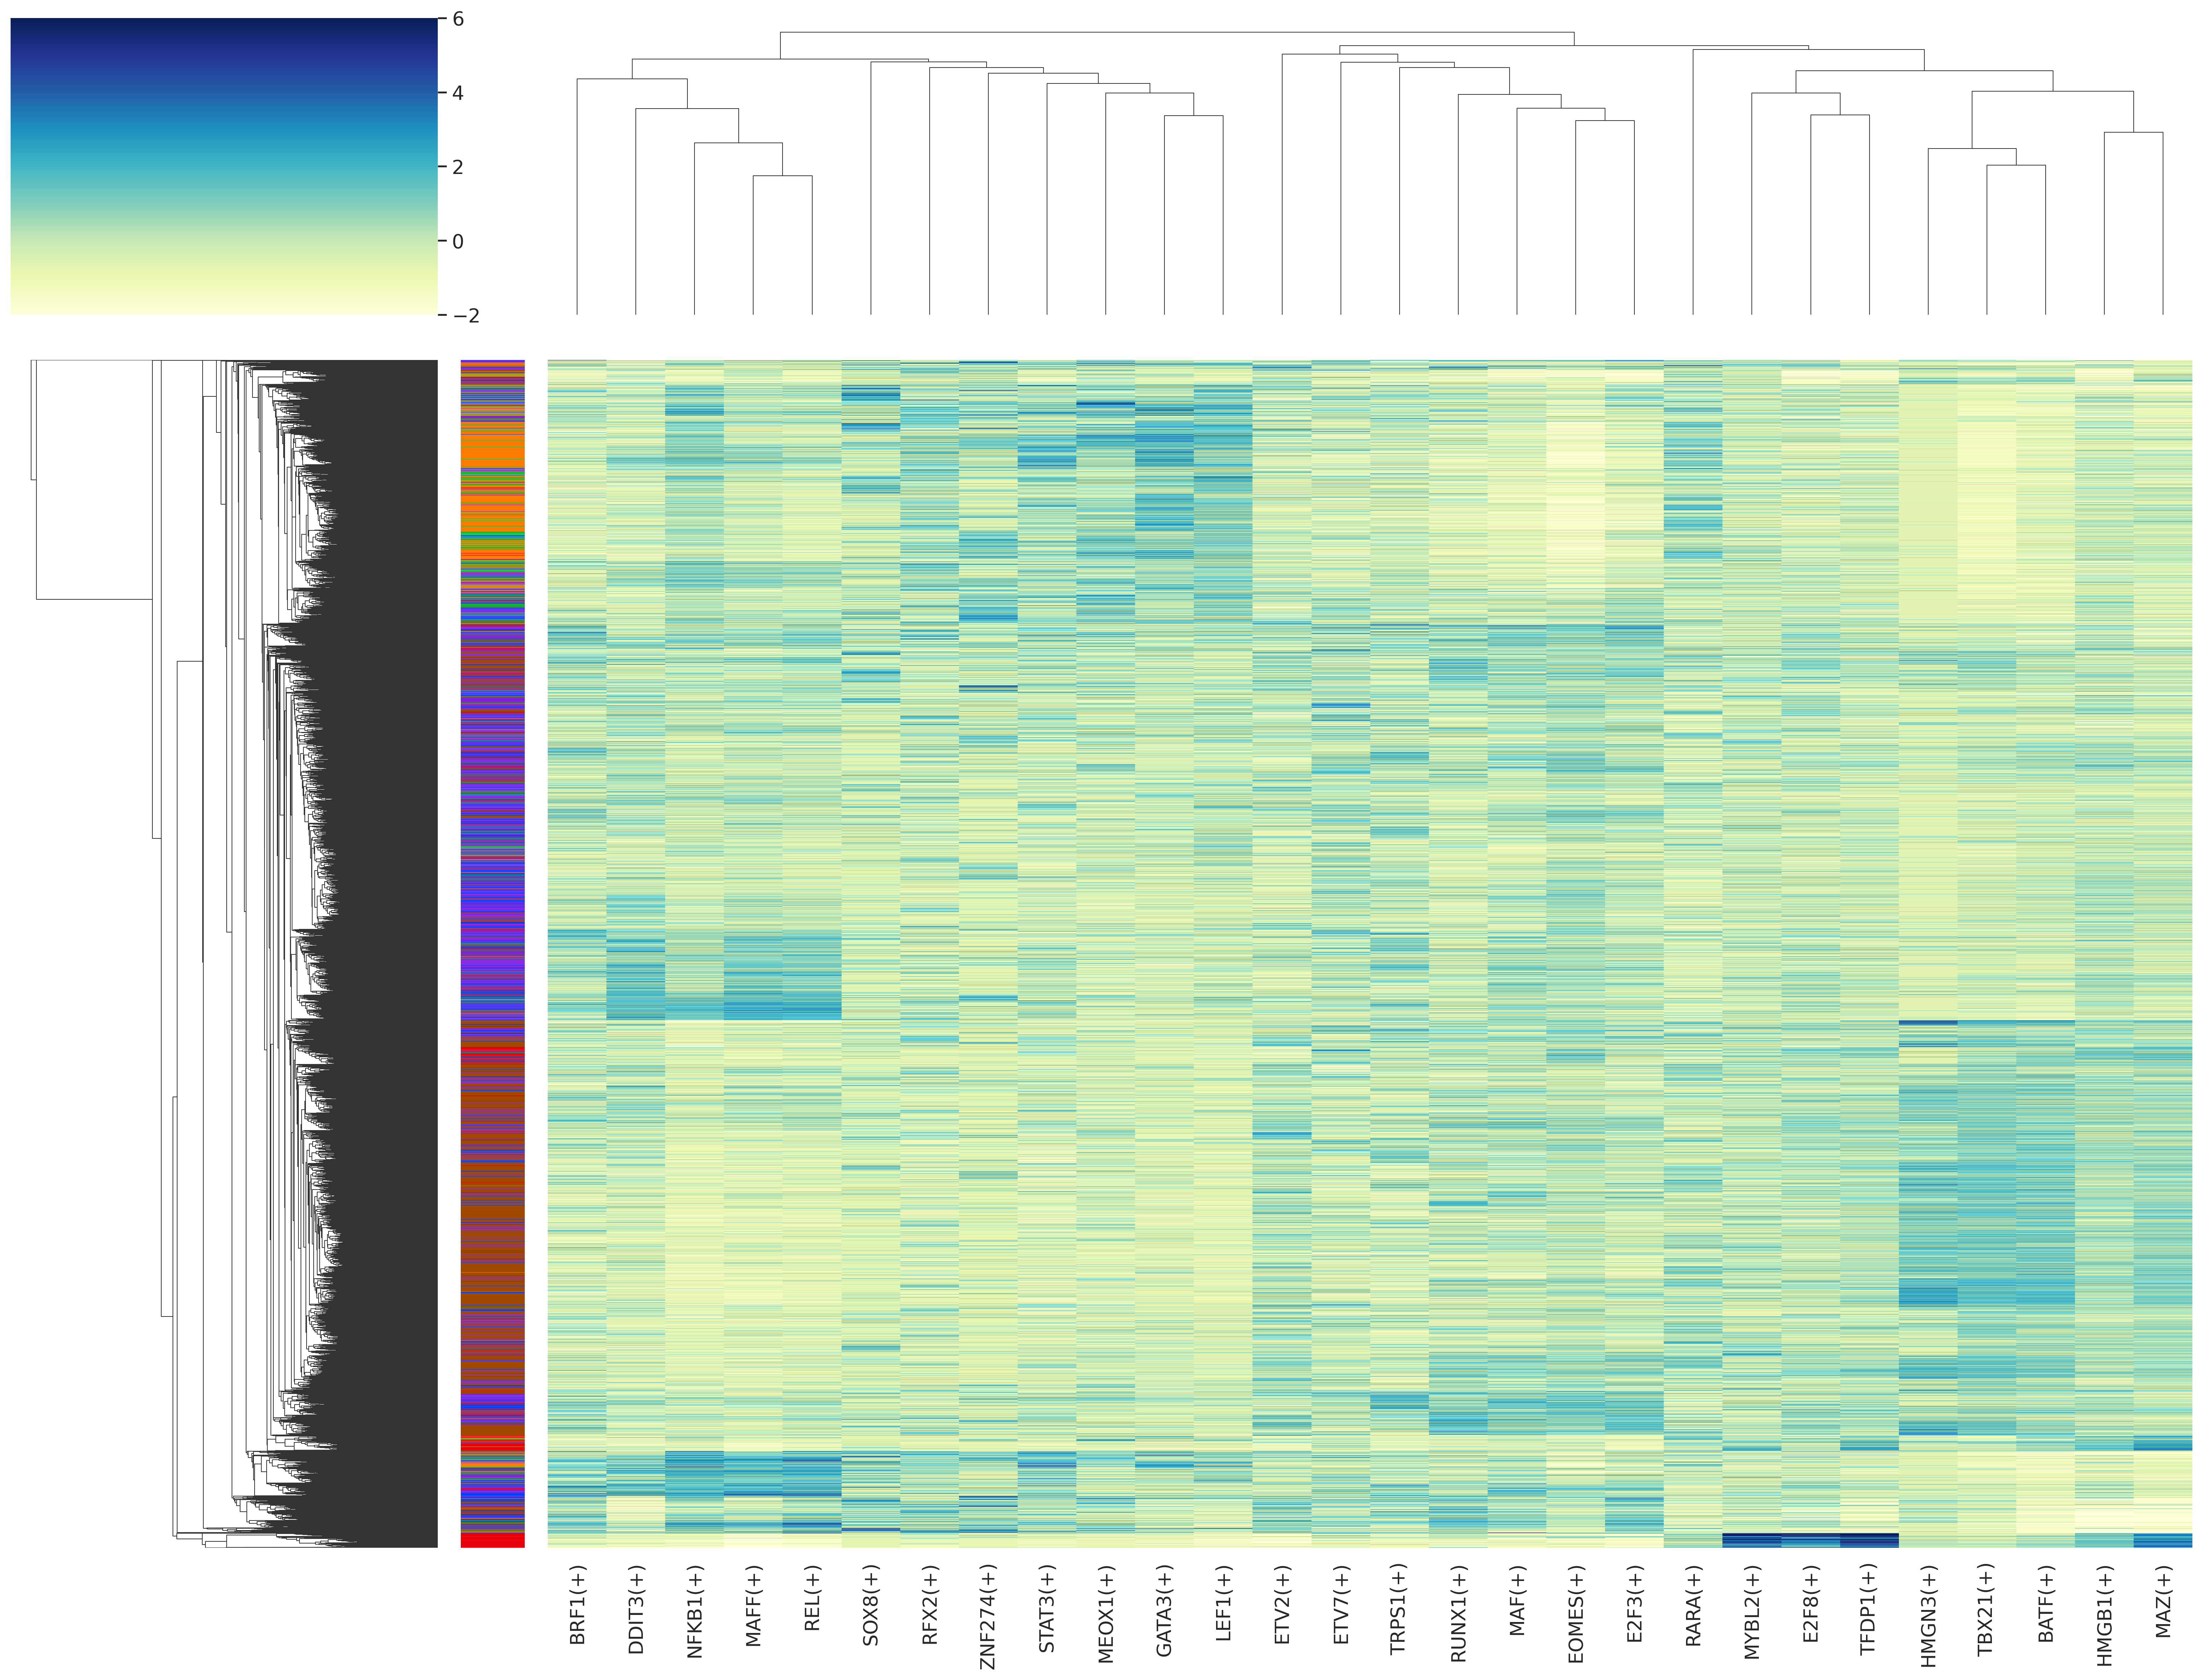

In [59]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')

In [60]:
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=25 )
binary_mtx.head()

,AHR(+),ARID3A(+),ARID5A(+),ARNTL2(+),ATF3(+),ATF4(+),ATF5(+),ATF6(+),ATF6B(+),ATF7(+),...,ZNF607(+),ZNF66(+),ZNF677(+),ZNF76(+),ZNF768(+),ZNF772(+),ZNF85(+),ZNF91(+),ZSCAN10(+),ZSCAN31(+)
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
33,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
40,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,1,0
54,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0


/home/icb/goeksu.avar/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/icb/goeksu.avar/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/icb/goeksu.avar/anaconda3/envs/pyscenic/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use e

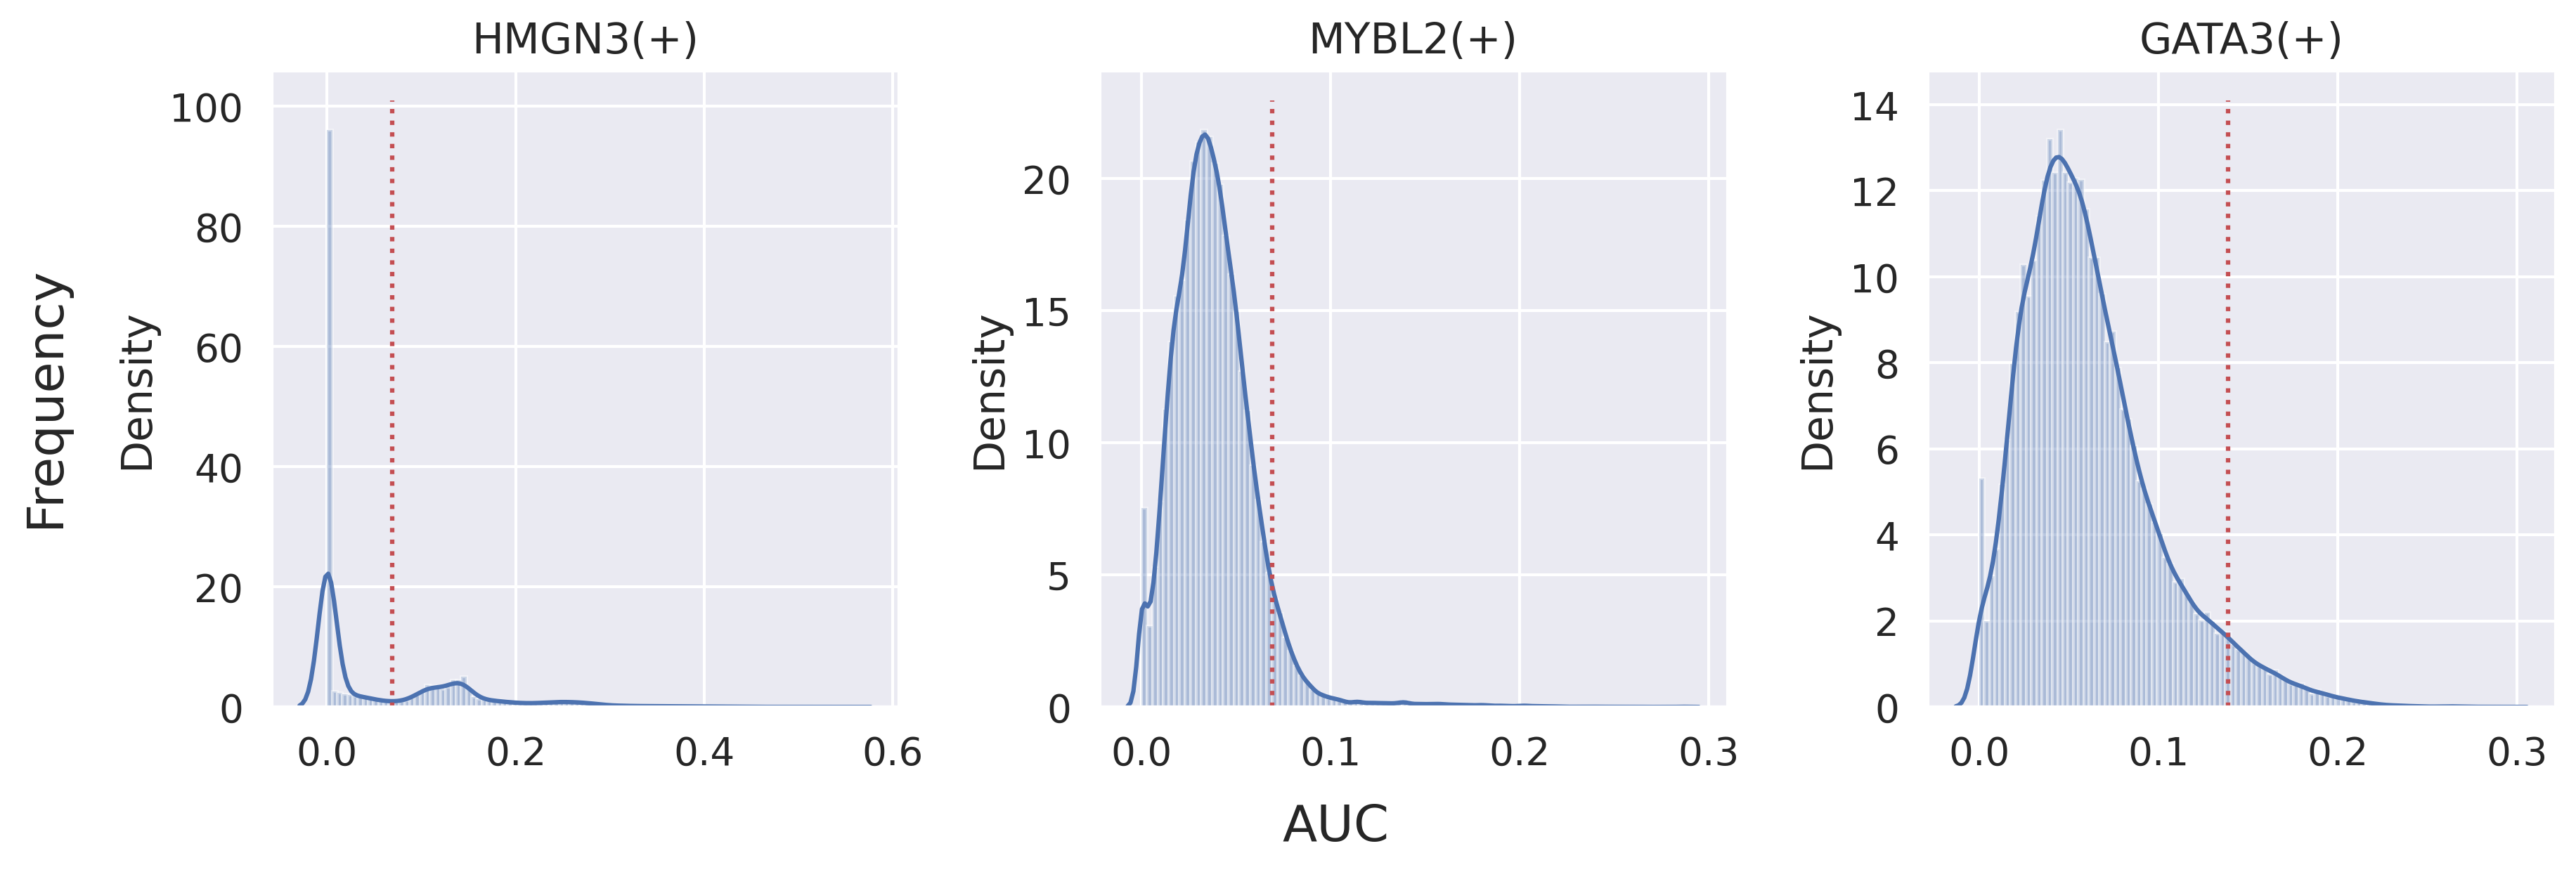

In [62]:
# select regulons:
r = [ 'HMGN3(+)', 'MYBL2(+)', 'GATA3(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()

In [64]:
adjacencies = pd.read_csv("adj_CD8.tsv", index_col=False, sep='\t')


In [65]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))


2021-12-17 15:01:50,805 - pyscenic.utils - INFO - Calculating Pearson correlations.
Calculating Pearson correlations.

2021-12-17 15:01:51,901 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].
Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero e

In [67]:
tf = 'GATA3'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"(+)"])} genes' )

GATA3 module 0: 1715 genes
GATA3 module 1: 993 genes
GATA3 module 2: 51 genes
GATA3 module 3: 290 genes
GATA3 module 4: 472 genes
GATA3 module 5: 1319 genes
GATA3 regulon: 37 genes


In [68]:
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons[tf+'(+)']:
        f.write("%s\n" % item)